[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mengyulin/CoastalEngineering/blob/master/Showcase/Chap_7/2_FFT.ipynb)


# Frequency and the fast Fourier transform

> If you want to find the secrets of the universe, think in terms of energy,
> frequency and vibration.
>
> — Nikola Tesla

*This chapter was written in collaboration with SW's father, PW van der Walt.*

This chapter will depart slightly from the format of the rest of the
book.  In particular, you may find the *code* in the chapter quite
modest.  Instead, we want to illustrate an elegant *algorithm*, the
Fast Fourier Transform (FFT), that is endlessly useful, implemented in
SciPy, and works, of course, on NumPy arrays.

## Discrete Fourier transforms

The Discrete Fourier Transform (DFT) converts a sequence of $N$
equally spaced real or complex samples $x_{0,}x_{1,\ldots x_{N-1}}$ of
a function $x(t)$ of time into a sequence of $N$ complex numbers $X_{k}$ by the
summation

 $$X_{k}=\sum_{n=0}^{N-1}x_{n}e^{-j2\pi kn/N},\;k=0,1,\ldots
 N-1.$$

 With the numbers $X_{k}$ known, the inverse DFT *exactly* recovers the
 sample values $x_{n}$ through the summation

 $$x_{n}=\frac{1}{N}\sum_{k=0}^{N-1}X_{k}e^{j2\pi kn/N}.$$

Keeping in mind that $e^{j\theta}=\cos\theta+j\sin\theta,$ the last
 equation shows that the DFT has decomposed the sequence $x_{n}$ into a
 complex discrete Fourier series with coefficients $X_{k}$. Comparing
 the DFT with a continuous complex Fourier series

 $$x(t)=\sum_{n=-\infty}^{\infty}c_{n}e^{jn\omega_{0}t},$$

 the DFT is a *finite *series with $N$ terms defined at the equally
 spaced discrete instances of the *angle* $(\omega_{0}t_{n})=2\pi\frac{k}{N}$
 in the interval $[0,2\pi)$,
 i.e. *including* $0$  and *excluding* $2\pi$.
 This automatically normalizes the DFT so that time does
 not appear explicitly in the forward or inverse transform.

If the original function $x(t)$ is limited in frequency to less than
 half of the sampling frequency (the so-called *Nyquist frequency*),
 interpolation between sample values produced by the inverse DFT will
 usually give a faithful reconstruction of $x(t)$. If $x(t)$ is *not*
 limited as such, the inverse DFT can, in general, not be used to
 reconstruct $x(t)$ by interpolation.

## Introducing frequency

We'll start by setting up some plotting styles and importing the usual
suspects:

In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

In [2]:
import numpy as np

The discrete Fourier transform (DFT) is a mathematical technique
to convert temporal or spatial data into *frequency domain* data.

If you take a simple periodic function, $\sin(10 \times 2 \pi t)$, you can view it as a wave:

(Note: since the sampling spacing $dt = 1/100 = 0.01$, the output frequencies $f_k = -1/(2dt) \sim 1/(2dt) = -50 \sim 50$.)

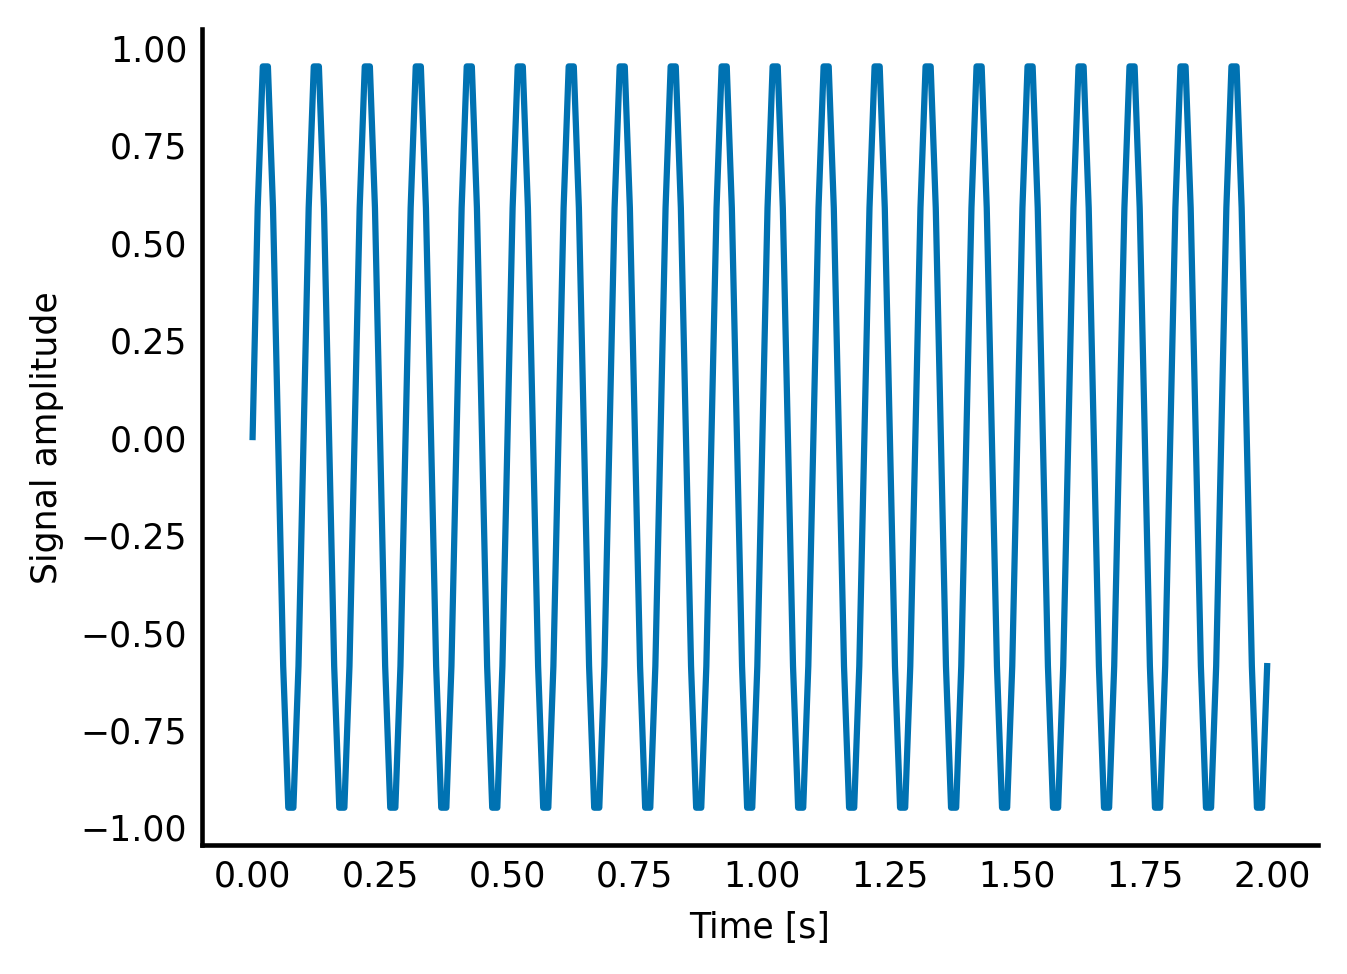

In [3]:
f = 10  # Frequency, in cycles per second, or Hertz
f_s = 100  # Sampling rate, or number of measurements per second

N = 2 * f_s  # Total number of points
dt = 1 / f_s # Time interval of points
t = np.linspace(0, 2, N, endpoint=False)
x = np.sin(f * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

<!-- caption text="A simple periodic function in time" -->

Or you can equivalently think of it as a repeating signal of
*frequency* 10 Hertz (it repeats once every $1/10$ seconds—a length of
time we call its *period*).  Although we naturally associate frequency
with time, it can equally well be applied to space.  E.g., a
photo of a textile patterns exhibits high *spatial frequency*, whereas
the sky or other smooth objects have low spatial frequency.

Let us now examine our sinusoid through application of the discrete Fourier
transform:

<StemContainer object of 3 artists>

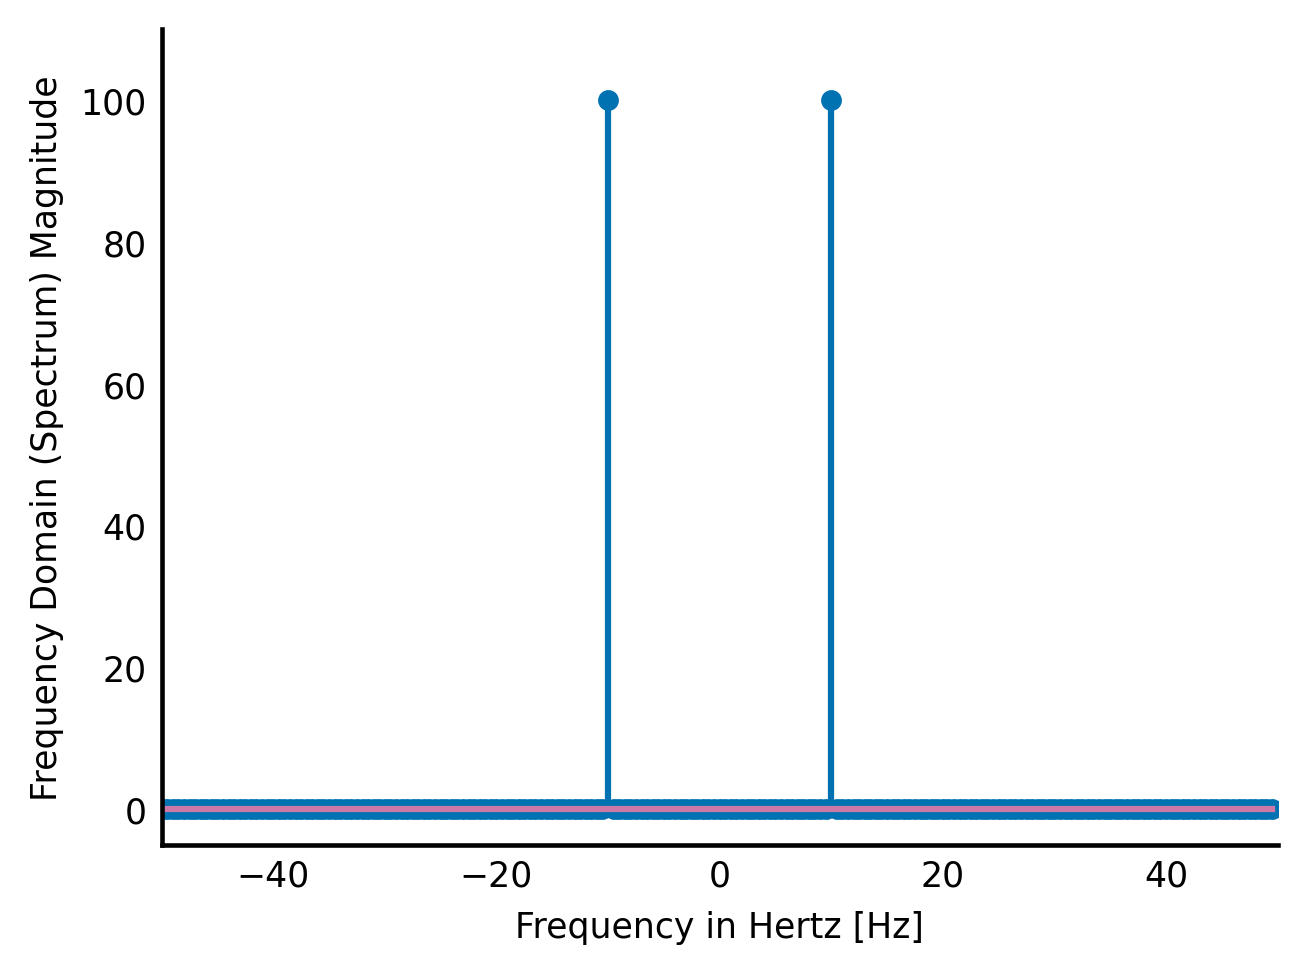

In [4]:
from scipy import fft      # 載入 FFT 函式庫

X = fft.fft(x)
freqs = fft.fftfreq(N, d=dt)

fig, ax = plt.subplots()

ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)
ax.stem(freqs, np.abs(X))

將 FFT 輸出之強度乘以 2/N，即可表示為分頻波之振幅。由於原數據為 $\sin(10 \times 2 \pi t)$ 所產生，故 FFT 之成果為單一頻率 ($f = 10$)，振幅則為 1。

<StemContainer object of 3 artists>

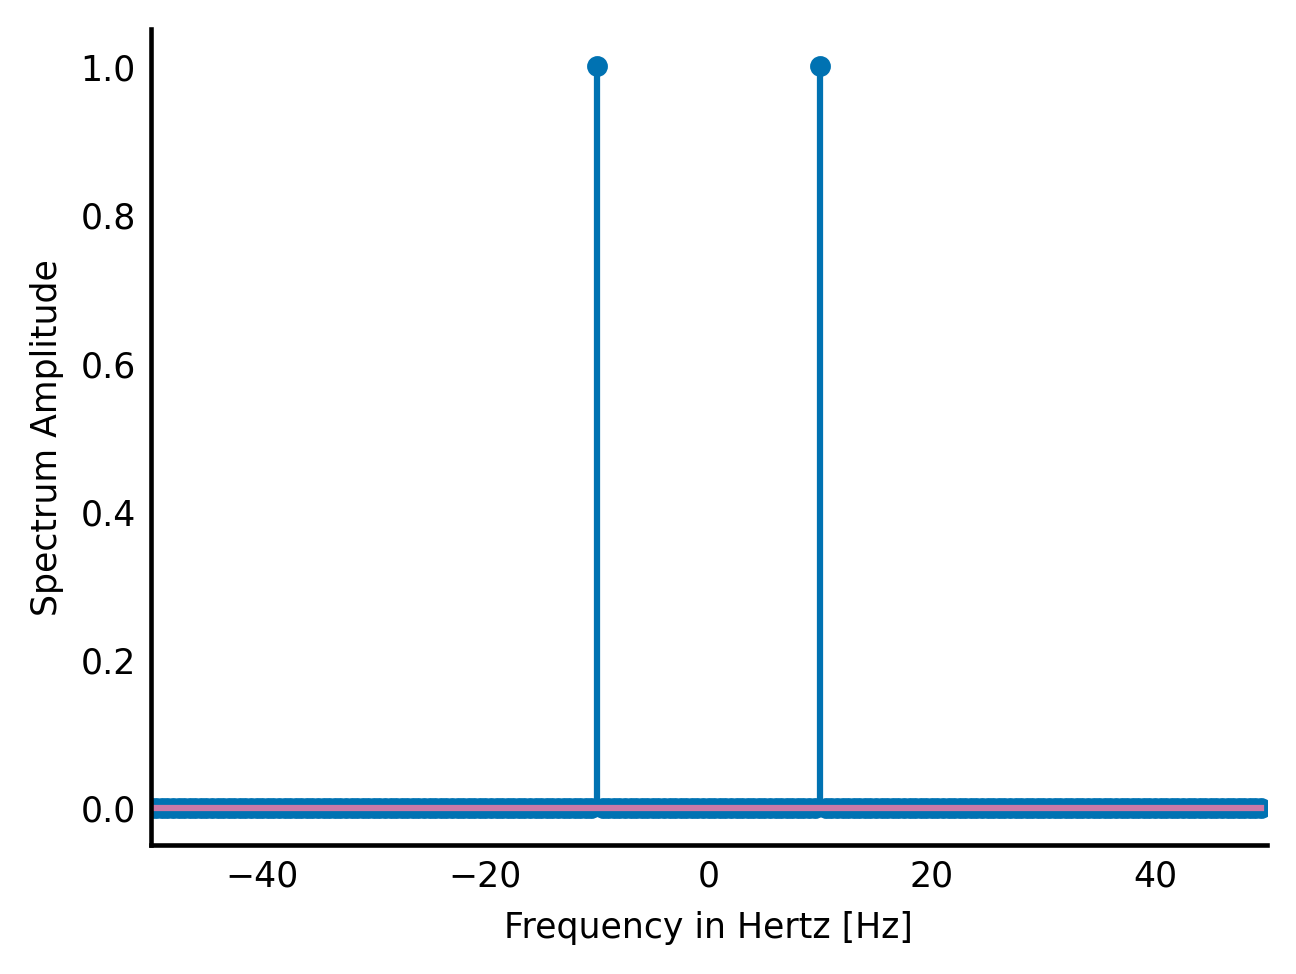

In [5]:
fig, ax = plt.subplots()

ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Spectrum Amplitude')
ax.set_xlim(-f_s / 2, f_s / 2)
#ax.set_ylim(-5, 110)
ax.stem(freqs, np.abs(X) * (2/N))

<!-- caption text="Frequencies that make up our periodic signal above" -->

We see that the output of the FFT is a one-dimensional array of the
same shape as the input, containing complex values.  All values are
zero, except for two entries.  Traditionally, we visualize the
magnitude of the result as a *stem plot*, in which the height of each
stem corresponds to the underlying value.

(We explain why you see positive and negative frequencies later on
in the sidebox titled "Discrete Fourier transforms".  You may also
refer to that section for a more in-depth overview of the underlying
mathematics.)

### 範例：成分波為不同頻率、振幅之正弦波

設定資料為五個頻率、振幅不同之正弦波：

$$y = \sum_{i=1}^5 A_i\sin(2\pi f_i t)$$

若令 $f_1$ 為最小的頻率 (有最大的週期 $T_1$)，則總時間長度設為兩個週期：$2T_1 = 2/f_1$。

In [6]:
N = 4096         # 採樣總數
f1, f2, f3, f4, f5 = 10, 30, 50, 70, 90
A1, A2, A3, A4, A5 = 0.5, 0.4, 0.3, 0.2, 0.1
dt = (2/f1) / N  # 採樣時間間隔

t = np.linspace(0, 2/f1, N, endpoint=False)
y = A1*np.sin(2*np.pi*f1*t) + A2*np.sin(2*np.pi*f2*t) + A3*np.sin(2*np.pi*f3*t) + \
    A4*np.sin(2*np.pi*f4*t) + A5*np.sin(2*np.pi*f5*t)

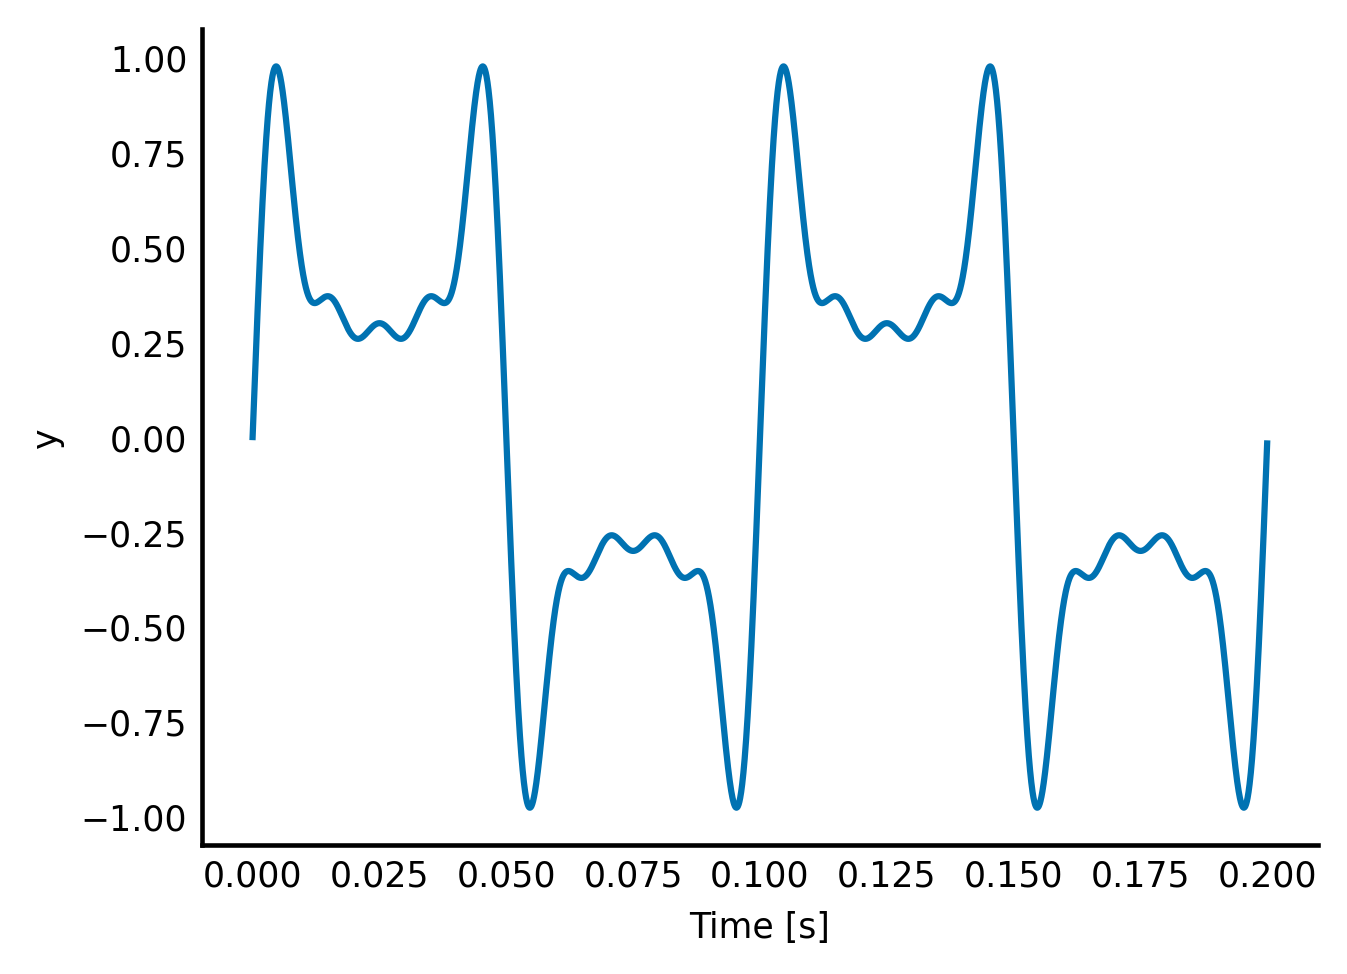

In [7]:
fig, ax = plt.subplots()

ax.plot(t, y)
ax.set_xlabel('Time [s]');
ax.set_ylabel('y');

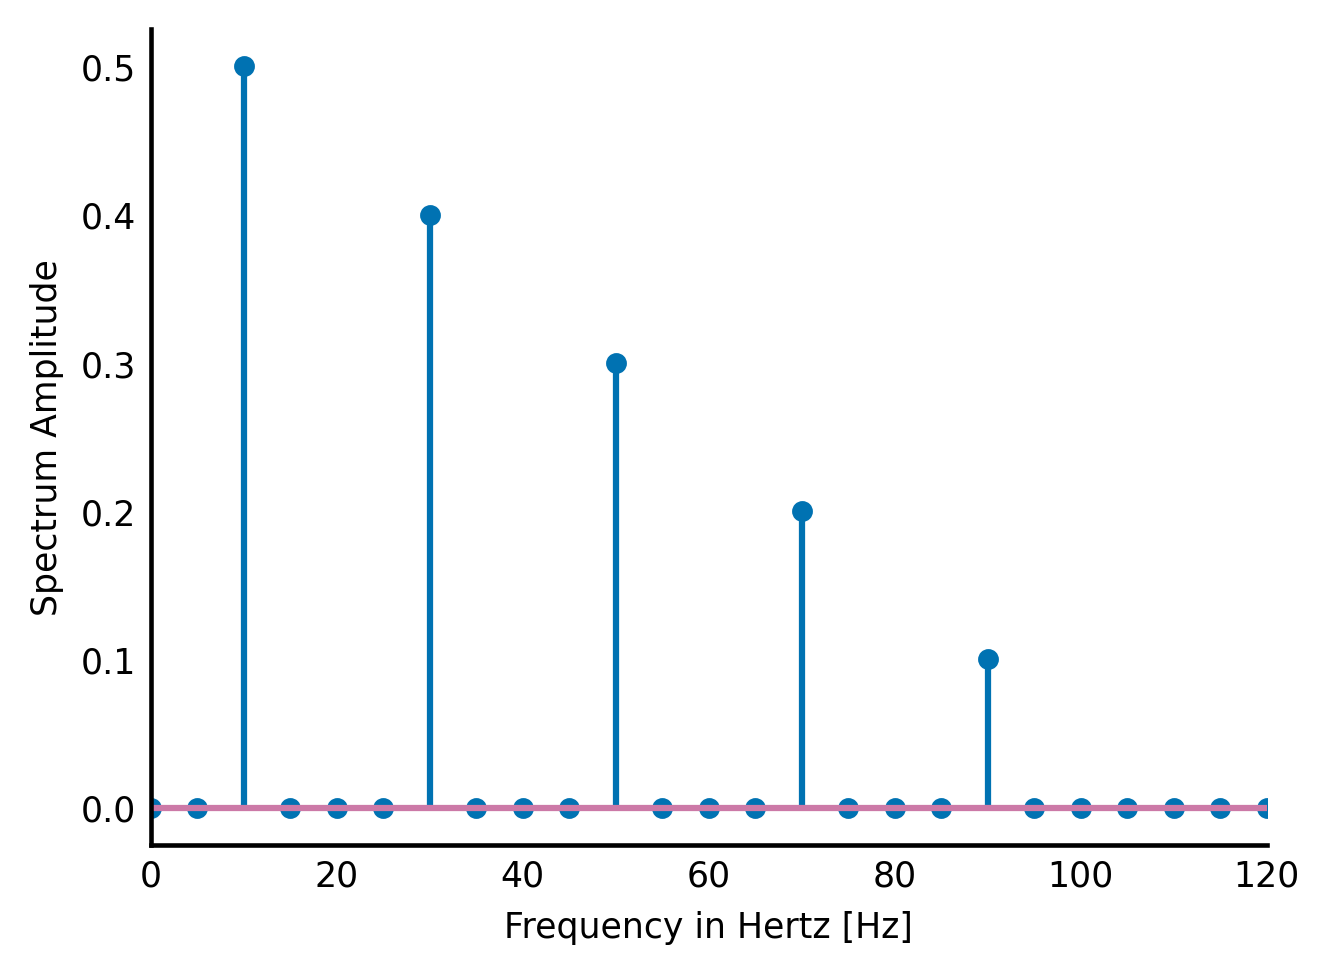

In [8]:
yf = fft.fft(y)
xf = fft.fftfreq(N, dt)

fig, ax = plt.subplots()
ax.stem(xf, np.abs(yf) * (2/N))
ax.set_xlabel('Frequency in Hertz [Hz]');
ax.set_ylabel('Spectrum Amplitude');
ax.set_xlim(0, 120);
#ax.set_ylim(-5, 110);

## More discrete Fourier transform concepts

Next, we present a couple of common concepts worth knowing before
operating heavy Fourier transform machinery, whereafter we tackle
another real-world problem: analyzing target detection in radar data.

### Frequencies and their ordering

For historical reasons, most implementations return an array where
frequencies vary from low-to-high-to-low (see the box "Discrete
Fourier transforms" for further explanation of frequencies).  E.g., when we do the real
Fourier transform of a signal of all ones, an input that has no
variation and therefore only has the slowest, constant Fourier
component (also known as the "DC" or Direct Current component—just
electronics jargon for "mean of the signal"), appearing as the first
entry:

In [9]:
N = 10
x = np.ones(N)
print(f'Applying FFT to {x}')

fft.fft(x)  # The first component is np.mean(x) * N

Applying FFT to [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


array([10.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,  0.-0.j,
        0.-0.j,  0.-0.j,  0.-0.j])

When we try the FFT on a rapidly changing signal, we see a high
frequency component appear:

In [10]:
z = np.ones(10)
z[::2] = -1

print(f'Applying FFT to {z}')
fft.fft(z)

Applying FFT to [-1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]


array([  0.-0.j,   0.+0.j,   0.+0.j,   0.+0.j,   0.+0.j, -10.-0.j,
         0.-0.j,   0.-0.j,   0.-0.j,   0.-0.j])

Note that the FFT returns a complex spectrum which, in the case of
real inputs, is conjugate symmetrical (i.e., symmetric in the real
part, and anti-symmetric in the imaginary part):

In [11]:
x = np.array([1, 5, 12, 7, 3, 0, 4, 3, 2, 8])
X = fft.fft(x)

with np.printoptions(precision=2):
    print("Real part:     ", X.real)
    print("Imaginary part:", X.imag)

Real part:      [ 45.     7.09 -12.24  -4.09  -7.76  -1.    -7.76  -4.09 -12.24   7.09]
Imaginary part: [ -0.   -10.96  -1.62  12.03   6.88  -0.    -6.88 -12.03   1.62  10.96]


(And, again, recall that the first component is ``np.mean(x) * N``.)

The `fftfreq` function tells us which frequencies we are looking at
specifically:

In [12]:
fft.fftfreq(10,d=0.1)  # N = 10, dt = 0.1 (df = 1.0)

array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])

<!-- caption text="Filtered moon landing image and its spectrum" -->

### 方波與非週期性訊號

若對一個方波進行 Fourier 轉換，可以看到頻譜中旁邊出現許多小峰值：

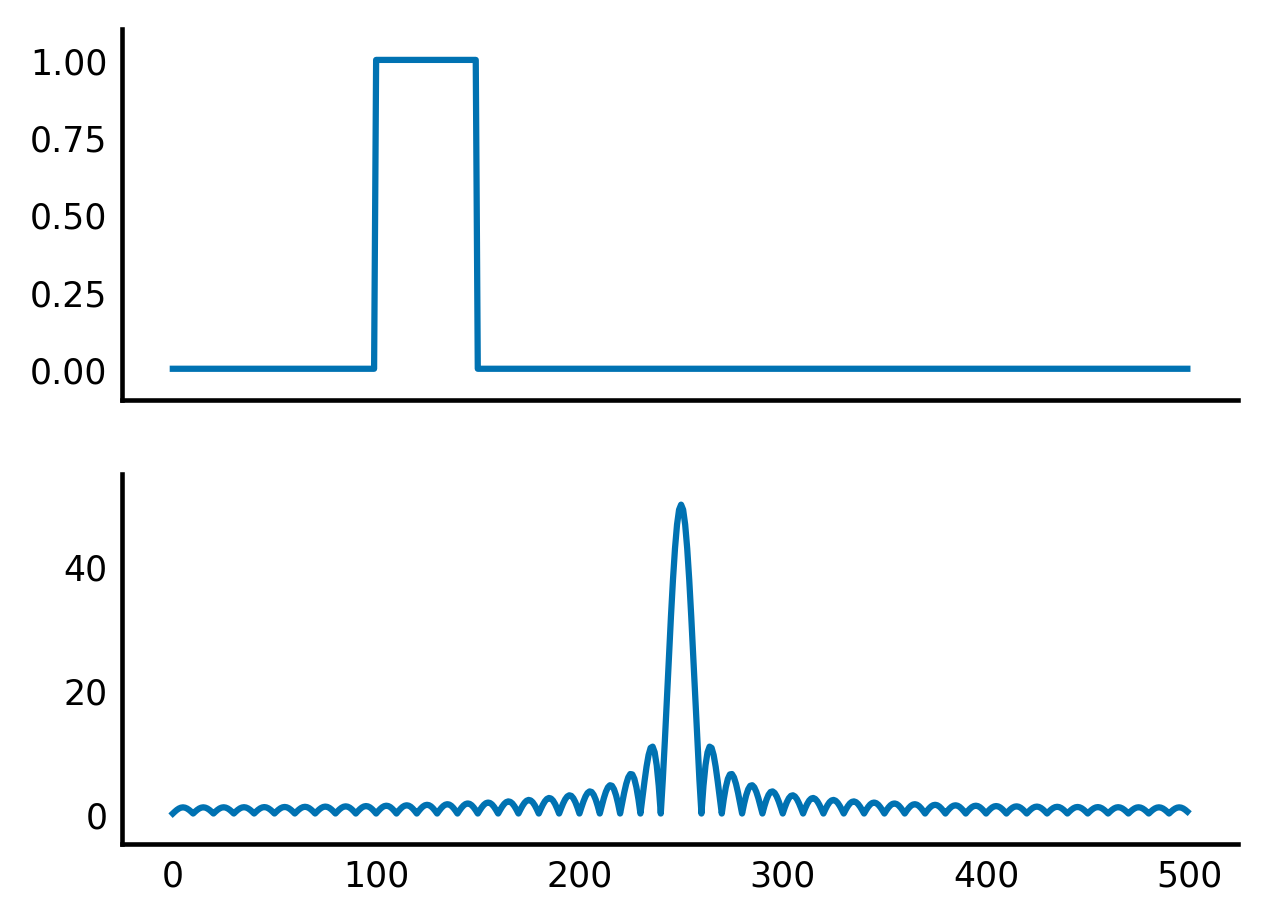

In [13]:
x = np.zeros(500)
x[100:150] = 1

X = fft.fft(x)

f, (ax0, ax1) = plt.subplots(2, 1, sharex=True)

ax0.plot(x)
ax0.set_ylim(-0.1, 1.1)

ax1.plot(fft.fftshift(np.abs(X)))
ax1.set_ylim(-5, 55);

理論上，需要結合無限多的正弦波（頻率）才能表示出方波的突然變化。因此頻率係數的主峰值旁會出現許多小峰值。

<!-- caption text="Spectrum of a rectangular pulse (magnitude)" -->

重要的是，離散傅立葉變換假設輸入訊號是週期性的。如果訊號不是週期性的，假設就是在訊號的末端，它會跳回到其起始值。例如此處所示的函數$x(t)$：

<img src="./figures/periodic.png"/>
<!-- caption text="Eight samples have been taken of a given
 function with effective length $T_{eff}$.  With the discrete Fourier
 transform assuming periodicity, it creates a step discontinuity
 between the first and last samples." -->

我們只測量一段短時間的訊號，標記為 $T_{eff}$。傅立葉轉換假定 $x(8) = x(0)$，並且訊號會以虛線而非實線的方式繼續。這在邊緣引入了一個大跳躍，而頻譜中會有預期的振盪。

#### 非週期性訊號

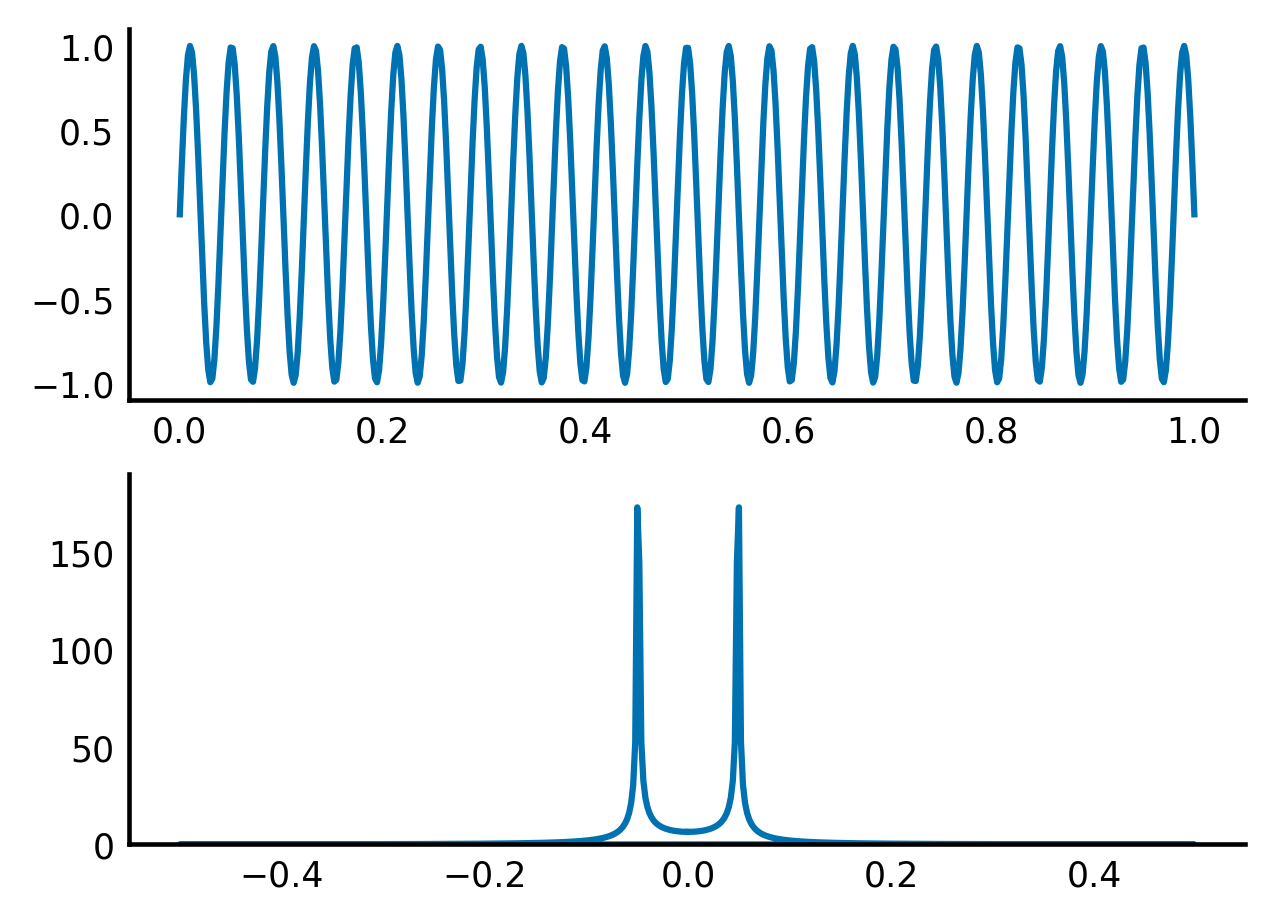

In [14]:
t = np.linspace(0, 1, 500)
x = np.sin(49 * np.pi * t)

X = fft.fft(x)

f, (ax0, ax1) = plt.subplots(2, 1)

ax0.plot(t,x)
ax0.set_ylim(-1.1, 1.1)

ax1.plot(fft.fftfreq(len(t)), np.abs(X))
ax1.set_ylim(0, 190);

#### 週期性訊號

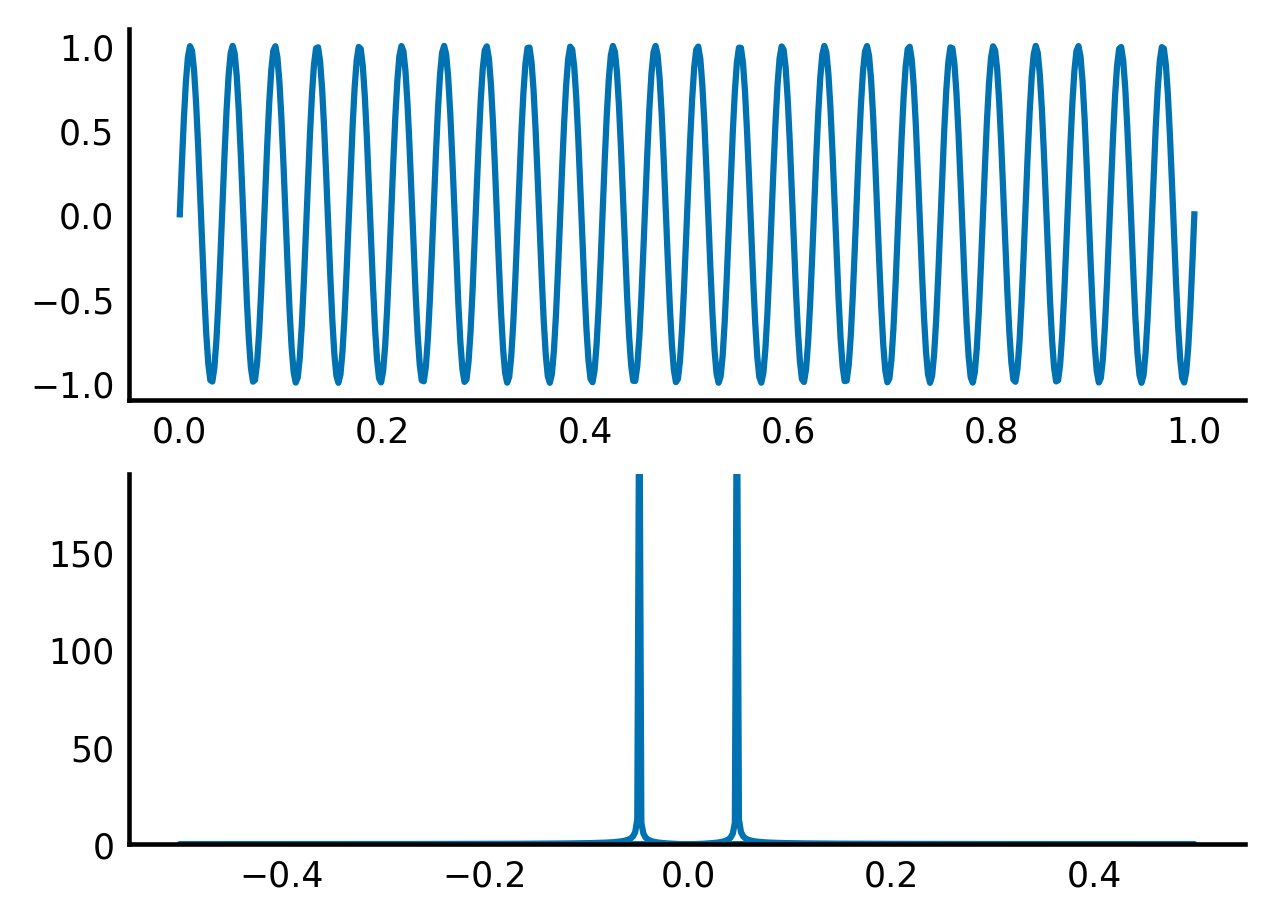

In [15]:
t = np.linspace(0, 1, 500)
x = np.sin(48 * np.pi * t)

X = fft.fft(x)

f, (ax0, ax1) = plt.subplots(2, 1)

ax0.plot(t,x)
ax0.set_ylim(-1.1, 1.1)

ax1.plot(fft.fftfreq(len(t)), np.abs(X))
ax1.set_ylim(0, 190);

<!-- solution end -->

<!-- exercise end -->